# Project 3

Assignment: "Test whether the data is consistent with racial differences in police use of force."

## Setup 

In [124]:
# Set path and import packages
from sys import path
import numpy as np
import pandas as pd 
from scipy.stats import norm
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme()

# Reloads so the kernel won't have to be restarted when changes are made in the other files
%load_ext autoreload
%autoreload 2

# Estimation?
import project3_estimation as est 

# For the linear probability model
import project3_LinearModel as lm

# For probit
import project3_probit

# For logit
import project3_logit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Data


In [125]:
# Inspect data 
dat = pd.read_csv('ppcs_cc.csv')
desc = dat.describe()
print(desc)

# Things to note:
 # year is always 2011
 # osplit is always 0
 # 90.4% of observations are involving one or a majority of white officers

            sblack        shisp       swhite       sother        smale  \
count  3799.000000  3799.000000  3799.000000  3799.000000  3799.000000   
mean      0.110555     0.101606     0.739142     0.048697     0.529613   
std       0.313622     0.302169     0.439160     0.215262     0.499188   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     1.000000     0.000000     1.000000   
75%       0.000000     0.000000     1.000000     0.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

              sage        sempl      sincome         spop      daytime  \
count  3799.000000  3799.000000  3799.000000  3799.000000  3799.000000   
mean     41.010003     0.695446     2.164780     1.362727     0.666491   
std      16.146916     0.460279     0.848262     0.765598     0.471529   
min      16.000000     0.000000     1

In [126]:
# Converting the above to a Latex table
desc = desc.loc[['mean', 'std']]

descriptive_stat = desc.to_latex(float_format="%.3f")

print(descriptive_stat)

\begin{tabular}{lrrrrrrrrrrrrrrrrrrr}
\toprule
 & sblack & shisp & swhite & sother & smale & sage & sempl & sincome & spop & daytime & inctype_lin & omajblack & omajhisp & omajwhite & omajother & osplit & sbehavior & year & anyuseofforce_coded \\
\midrule
mean & 0.111 & 0.102 & 0.739 & 0.049 & 0.530 & 41.010 & 0.695 & 2.165 & 1.363 & 0.666 & 1.958 & 0.061 & 0.024 & 0.904 & 0.012 & 0.000 & 0.065 & 2011.000 & 0.005 \\
std & 0.314 & 0.302 & 0.439 & 0.215 & 0.499 & 16.147 & 0.460 & 0.848 & 0.766 & 0.472 & 0.200 & 0.239 & 0.153 & 0.295 & 0.107 & 0.000 & 0.247 & 0.000 & 0.071 \\
\bottomrule
\end{tabular}



In [127]:
cases_omajwhite = ((dat['omajwhite'] == 1) & (dat['anyuseofforce_coded'] == 1)).sum()
print(cases_omajwhite)

18


In [128]:
cases_omajnotwhite = ((dat['omajwhite'] != 1) & (dat['anyuseofforce_coded'] == 1)).sum()
print(cases_omajnotwhite)

1


In [129]:
cases_omajnotwhite = ((dat['omajhisp'] == 1) & (dat['anyuseofforce_coded'] == 1)).sum()
print(cases_omajnotwhite)

1


In [130]:
# Decide what variables go into the estimation
y = 'anyuseofforce_coded'
x = ['const', 'sblack','shisp','sother','smale', 'sempl','sincome','spop','daytime','sbehavior','age','omajwhite'] 

In [131]:
# Load all data
dat = pd.read_csv('ppcs_cc.csv')
print(dat.head())

N = dat.shape[0]

# Create the constant
dat['const'] = np.ones((N,))

# Divede age with 10
dat['age'] = dat['sage']/10



   sblack  shisp  swhite  sother  smale  sage  sempl  sincome  spop  daytime  \
0       1      0       0       0      1    18      0        1     1        1   
1       1      0       0       0      1    20      1        2     4        0   
2       1      0       0       0      1    22      1        2     3        1   
3       1      0       0       0      1    22      1        3     1        1   
4       1      0       0       0      1    22      1        1     1        1   

   inctype_lin  omajblack  omajhisp  omajwhite  omajother  osplit  sbehavior  \
0            2          0         0          1          0       0          0   
1            2          0         0          1          0       0          0   
2            2          0         0          1          0       0          0   
3            2          0         0          1          0       0          0   
4            2          0         0          1          0       0          0   

   year  anyuseofforce_coded  
0  2011

In [132]:
print(dat['const'])

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
3794    1.0
3795    1.0
3796    1.0
3797    1.0
3798    1.0
Name: const, Length: 3799, dtype: float64


In [133]:
print(dat['age'])

0       1.8
1       2.0
2       2.2
3       2.2
4       2.2
       ... 
3794    7.2
3795    7.1
3796    7.6
3797    7.9
3798    7.5
Name: age, Length: 3799, dtype: float64


In [134]:
# Reorder columns and keep only the chosen variables
dat = dat[[y] + x].copy()

print(dat.head())

assert dat.notnull().all(axis=1).all(), 'There are missing'

   anyuseofforce_coded  const  sblack  shisp  sother  smale  sempl  sincome  \
0                    0    1.0       1      0       0      1      0        1   
1                    0    1.0       1      0       0      1      1        2   
2                    0    1.0       1      0       0      1      1        2   
3                    0    1.0       1      0       0      1      1        3   
4                    0    1.0       1      0       0      1      1        1   

   spop  daytime  sbehavior  age  omajwhite  
0     1        1          0  1.8          1  
1     4        0          0  2.0          1  
2     3        1          0  2.2          1  
3     1        1          0  2.2          1  
4     1        1          0  2.2          1  


In [135]:
print(dat.head())
print(dat.describe())

   anyuseofforce_coded  const  sblack  shisp  sother  smale  sempl  sincome  \
0                    0    1.0       1      0       0      1      0        1   
1                    0    1.0       1      0       0      1      1        2   
2                    0    1.0       1      0       0      1      1        2   
3                    0    1.0       1      0       0      1      1        3   
4                    0    1.0       1      0       0      1      1        1   

   spop  daytime  sbehavior  age  omajwhite  
0     1        1          0  1.8          1  
1     4        0          0  2.0          1  
2     3        1          0  2.2          1  
3     1        1          0  2.2          1  
4     1        1          0  2.2          1  
       anyuseofforce_coded   const       sblack        shisp       sother  \
count          3799.000000  3799.0  3799.000000  3799.000000  3799.000000   
mean              0.005001     1.0     0.110555     0.101606     0.048697   
std               

In [136]:
y = dat.anyuseofforce_coded.values # .reshape(N,1)
x = dat[x].values
K = x.shape[1]

In [137]:
# Generate labels
y_label = 'force'
x_label = ['const', 'sblack', 'shisp','sother','smale', 'sempl','sincome','spop','daytime','sbehavior','age','omajwhite'] 

# 2. Estimate using LPM

In [138]:
ols_results = lm.estimate(y, x, robust_se=True)
ols_tab = lm.print_table((y_label, x_label), ols_results, title='LPM results')
ols_tab

LPM results
Dependent variable: force

R2 = 0.027
sigma2 = nan


,b_hat,se,t
const,0.0013,0.0047,0.2713
sblack,0.0015,0.0045,0.3355
shisp,0.0088,0.0059,1.4940
sother,-0.0008,0.0058,-0.1415
smale,0.0048,0.0022,2.1305
sempl,-0.0066,0.0031,-2.1068
sincome,0.0007,0.0014,0.4885
spop,0.0044,0.0022,2.0369
daytime,-0.0029,0.0027,-1.0954
sbehavior,0.0369,0.0123,2.9881


# 3. Estimate using probit

The Probit model has the link function 
$$G^{\text{probit}}(\mathbf{x}_i \boldsymbol{\beta}) 
    =\Phi(\mathbf{x}_i \boldsymbol{\beta})
    \equiv \int_{-\infty}^{\mathbf{x}_i \boldsymbol{\beta}}\phi\left(z\right) \, \mathrm{d} z$$

$\phi\left(z\right)= (2 \pi)^{-\frac12}\exp(\frac{-z^{2}}{2})$ is the standard normal pdf. 

In [139]:
theta0 = project3_probit.starting_values(y, x)
theta0

array([ 0.00315599,  0.00376192,  0.02197351, -0.0020458 ,  0.01196241,
       -0.01647052,  0.00168227,  0.0109627 , -0.00730152,  0.09213609,
       -0.00450477,  0.01182574])

In [140]:
ll = project3_probit.loglikelihood(theta0, y, x)

In [141]:
import numpy as np
np.linalg.matrix_rank(x)


np.int64(12)

In [142]:
print(x.shape[1])

12


In [143]:
probit_results = est.estimate(project3_probit.q, theta0, y, x)

Optimization terminated successfully.
         Current function value: 0.023633
         Iterations: 81
         Function evaluations: 1131
         Gradient evaluations: 87


In [144]:
probit_tab = est.print_table(x_label, probit_results, title=f'Probit, y = {y_label}')
probit_tab

Optimizer succeeded after 81 iter. (1131 func. evals.). Final criterion:  0.02363.
Probit, y = force


,theta,se,t
const,-3.3781,1.4255,-2.3697
sblack,0.2467,0.3123,0.7898
shisp,0.4672,0.2779,1.6810
sother,0.0122,0.6354,0.0193
smale,0.5547,0.3840,1.4446
sempl,-0.4621,0.2851,-1.6208
sincome,0.0698,0.1717,0.4065
spop,0.2096,0.1489,1.4077
daytime,-0.1523,0.2938,-0.5184
sbehavior,1.0682,0.3594,2.9719


In [145]:
project3_probit.G(x @ probit_results['theta']).mean()

np.float64(0.004998037371095907)

$\bar{G(\mathbf{x}\boldsymbol{\beta})}$ is the mean predicted value of police using force. On average, 0.5% experience that police use force in their encounter.

# 4. Estimate using Logit
Estimate the logit model with maximum likelihood, using the same explanatory variables as in
**Question 3**.

## The Logit Model

For the Logit model, the link function is 

$$G^{\text{logit}}( \mathbf{x}_i \boldsymbol{\beta} ) = \Lambda(\mathbf{x}_i \boldsymbol{\beta}) \equiv  \frac{\exp(\mathbf{x}_i \boldsymbol{\beta})}{1+\exp(\mathbf{x}_i \boldsymbol{\beta})}= \frac{1}{1+\exp(-\mathbf{x}_i \boldsymbol{\beta})} \tag{2}$$


In [146]:
theta0 = project3_logit.starting_values(y, x)
theta0 

array([ 0.00504959,  0.00601907,  0.03515762, -0.00327328,  0.01913986,
       -0.02635283,  0.00269163,  0.01754032, -0.01168243,  0.14741774,
       -0.00720763,  0.01892118])

In [147]:
ll = project3_logit.loglikelihood(theta0, y, x)
np.isclose(np.mean(ll),-0.9974267061091704)

np.False_

In [148]:
logit_results = est.estimate(project3_logit.q, theta0, y, x)

Optimization terminated successfully.
         Current function value: 0.023572
         Iterations: 121
         Function evaluations: 1599
         Gradient evaluations: 123


In [149]:
logit_tab = est.print_table(x_label, logit_results, title=f'Logit, y = {y_label}')
logit_tab

Optimizer succeeded after 121 iter. (1599 func. evals.). Final criterion:  0.02357.
Logit, y = force


,theta,se,t
const,-6.7164,3.0898,-2.1737
sblack,0.4851,0.8466,0.5730
shisp,1.0450,0.6801,1.5365
sother,-0.4993,1.4892,-0.3353
smale,1.1367,0.8164,1.3923
sempl,-1.2479,0.6109,-2.0426
sincome,0.1779,0.3845,0.4627
spop,0.5596,0.3116,1.7958
daytime,-0.4131,0.6759,-0.6111
sbehavior,2.6967,0.7930,3.4005


In [150]:
project3_logit.G(x @ logit_results['theta']).mean()

np.float64(0.005006291204053723)

## Estimation table for Latex

In [151]:
def latex_table(models, varnames, model_names):
    """
    models: Estimates and standard errors
    varnames: List of variable names
    model_names: LPM, Logit, Probit
    """

    latex = "\\begin{table}[htbp]\n\\caption{Estimation results} \n\\centering\n\\begin{tabular}{l" + "c" * len(models) + "}\n"
    latex += "\\hline\n"
    latex += " & " + " & ".join(model_names) + " \\\\\n"
    latex += "\\hline\n"

    for i, var in enumerate(varnames):
        # coefficients row
        row = [f"{models[m]['coef'][i]:.4f}" for m in range(len(models))]
        latex += var + " & " + " & ".join(row) + " \\\\\n"

        # standard error row
        row = [f"({models[m]['se'][i]:.4f})" for m in range(len(models))]
        latex += " & " + " & ".join(row) + " \\\\\n"

    latex += "\\hline\n"
    latex += "\\end{tabular}\n\\end{table}"
    return latex


In [152]:
latex = latex_table(
    models = [
        {"coef": ols_results['b_hat'], "se": ols_results['se']},
        {"coef": probit_results['theta'], "se": probit_results['se']},
        {"coef": logit_results['theta'], "se": logit_results['se']}
    ],
    #varnames = ["Constant", "Black", "Hispanic", "Other","Male","Employment","Income","Population","Daytime","Incident type","Behavior","Age","White officer"],
    varnames = ["Constant", "Black", "Hispanic", "Other","Male","Employment","Income","Population","Daytime","Behavior","Age","White officer"],
    model_names = ["OLS", "Probit", "Logit"]
)

print(latex)

## We have set * to indicate significance manually.

\begin{table}[htbp]
\caption{Estimation results} 
\centering
\begin{tabular}{lccc}
\hline
 & OLS & Probit & Logit \\
\hline
Constant & 0.0013 & -3.3781 & -6.7164 \\
 & (0.0047) & (1.4255) & (3.0898) \\
Black & 0.0015 & 0.2467 & 0.4851 \\
 & (0.0045) & (0.3123) & (0.8466) \\
Hispanic & 0.0088 & 0.4672 & 1.0450 \\
 & (0.0059) & (0.2779) & (0.6801) \\
Other & -0.0008 & 0.0122 & -0.4993 \\
 & (0.0058) & (0.6354) & (1.4892) \\
Male & 0.0048 & 0.5547 & 1.1367 \\
 & (0.0022) & (0.3840) & (0.8164) \\
Employment & -0.0066 & -0.4621 & -1.2479 \\
 & (0.0031) & (0.2851) & (0.6109) \\
Income & 0.0007 & 0.0698 & 0.1779 \\
 & (0.0014) & (0.1717) & (0.3845) \\
Population & 0.0044 & 0.2096 & 0.5596 \\
 & (0.0022) & (0.1489) & (0.3116) \\
Daytime & -0.0029 & -0.1523 & -0.4131 \\
 & (0.0027) & (0.2938) & (0.6759) \\
Behavior & 0.0369 & 1.0682 & 2.6967 \\
 & (0.0123) & (0.3594) & (0.7930) \\
Age & -0.0018 & -0.1461 & -0.4236 \\
 & (0.0006) & (0.1930) & (0.4234) \\
White officer & 0.0047 & 0.5109 & 1.0427 

# 5. Comparing the raw parameter estimates 

A frequent rule of thumb is that the relationship between the parameter estimates is 
$$
\begin{aligned}
\hat{\boldsymbol{\beta}}_{Logit}&\simeq4\hat{\boldsymbol{\beta}}_{OLS}\\
\hat{\boldsymbol{\beta}}_{Probit}&\simeq2.5\hat{\boldsymbol{\beta}}_{OLS}\\
\hat{\boldsymbol{\beta}}_{Logit}&\simeq1.6\hat{\boldsymbol{\beta}}_{Probit}
\end{aligned}
$$

Test this by calculating the ratios between the estimated coefficients: 
$$\left(\frac{\hat{\boldsymbol{\beta}}_{Logit}}{\hat{\boldsymbol{\beta}}_{OLS}}, \frac{\hat{\boldsymbol{\beta}}_{Probit}}{\hat{\boldsymbol{\beta}}_{OLS}},\frac{\hat{\boldsymbol{\beta}}_{Logit}}{\hat{\boldsymbol{\beta}}_{Probit}} \right)$$



In [153]:
print('Probit / OLS')
print(probit_tab.theta / ols_tab.b_hat)

Probit / OLS
const       -2598.538462
sblack        164.466667
shisp          53.090909
sother        -15.250000
smale         115.562500
sempl          70.015152
sincome        99.714286
spop           47.636364
daytime        52.517241
sbehavior      28.948509
age            81.166667
omajwhite     108.702128
dtype: float64


In [154]:
print('Logit / OLS')
print(logit_tab.theta / ols_tab.b_hat)

Logit / OLS
const       -5166.461538
sblack        323.400000
shisp         118.750000
sother        624.125000
smale         236.812500
sempl         189.075758
sincome       254.142857
spop          127.181818
daytime       142.448276
sbehavior      73.081301
age           235.333333
omajwhite     221.851064
dtype: float64


In [155]:
print('Logit / Probit')
print(logit_tab.theta / probit_tab.theta)

Logit / Probit
const         1.988218
sblack        1.966356
shisp         2.236729
sother      -40.926230
smale         2.049216
sempl         2.700498
sincome       2.548711
spop          2.669847
daytime       2.712410
sbehavior     2.524527
age           2.899384
omajwhite     2.040908
Name: theta, dtype: float64


## 6. Estimating partial effects for sblack, shispanic, sother


For discrete variables the partial effects are given as,
$$
G\left(\beta_{0}+\beta_{1}x_{1}+\cdots+\beta_{K-1}x_{K-1}+\color{red}{\beta_{K}} \right)-G\left(\beta_{0}+\beta_{1}x_{1}+\cdots+\beta_{K-1}x_{K-1}\right)
$$

where $G$ is either $\Phi$ for the probit model, and $\Lambda$ for the logit.


In [156]:
# As the outcomes are discrete, we simply calculate the norm.cdf for our race dummy = 1 and substract it when the race dummy for white = 0
b_pr = probit_tab.theta.values
b_lg = logit_tab.theta.values

## 7. Estimating Average Partial Effect

In [157]:
import numpy as np

def average_partial_effect(x, beta, k, a, b, G):
    """
    Compute the average marginal effect of changing variable k from 0 to 1
    for any model with link function G.

    Parameters
    ----------
    X : np.array, shape (N, K)
        Matrix of covariates.
    beta : np.array, shape (K,)
        Estimated coefficients.
    k : int
        Index of the variable to switch from 0 to 1.
    G : callable
        Link function, e.g. probit or logit CDF. Must take a vector input.

    Returns
    -------
    float
        Average marginal effect of x_k: 0 → 1
    """

    # Copy X twice
    X0 = x.copy()
    X1 = x.copy()

    # Set the variable k to 0 and 1
    X0[:, k] = 0
    X1[:, k] = 1

    # Set the variable a to 0 always
    X0[:, a] = 0
    X1[:, a] = 0

    # Set the variable b to 0 always
    X0[:, b] = 0
    X1[:, b] = 0

    # Compute predicted probabilities for each individual
    p0 = G(X0 @ beta)
    p1 = G(X1 @ beta)

    # APE is the average difference
    APE = np.mean(p1 - p0)
    return APE


In [158]:
ape_probit_black = average_partial_effect(
    x=x,
    beta=b_pr,
    k=1,
    a=2,
    b=3,                     
    G=project3_probit.G
)

print("Probit APE for variable 1:", ape_probit_black)


Probit APE for variable 1: 0.002874119431651924


In [159]:
ape_logit_black = average_partial_effect(
    x=x,
    beta=b_lg,
    k=1,
    a=2,
    b=3,                        
    G=project3_logit.G
)

print("Logit APE for variable 1:", ape_logit_black)


Logit APE for variable 1: 0.002232552950563408


In [160]:
k=1

pd.DataFrame([ols_results['b_hat'][k], 
              ape_probit_black,
              ape_logit_black],
             index=['OLS', 'Probit', 'Logit'], columns=[f'Average Partial Eff.: {x_label[k]}']).round(6)

,Average Partial Eff.: sblack
OLS,0.001505
Probit,0.002874
Logit,0.002233


In [161]:
ape_probit_hispanic = average_partial_effect(
    x=x,
    beta=b_pr,
    k=2,
    a=1,
    b=3,                        
    G=project3_probit.G,
)

print("Probit APE for variable 2:", ape_probit_hispanic)


Probit APE for variable 2: 0.007023193768578782


In [162]:
ape_logit_hispanic = average_partial_effect(
    x=x,
    beta=b_lg,
    k=2,
    a=1,
    b=3,                        
    G=project3_logit.G
)

print("Logit APE for variable 2:", ape_logit_hispanic)


Logit APE for variable 2: 0.006298718065935642


In [163]:
k=2

pd.DataFrame([ols_results['b_hat'][k], 
              ape_probit_hispanic,
              ape_logit_hispanic],
             index=['OLS', 'Probit', 'Logit'], columns=[f'Average Partial Eff.: {x_label[k]}']).round(6)

,Average Partial Eff.: shisp
OLS,0.008789
Probit,0.007023
Logit,0.006299


In [164]:
ape_probit_other = average_partial_effect(
    x=x,
    beta=b_pr,
    k=3,
    a=1,
    b=2,                        
    G=project3_probit.G,
)

print("Probit APE for variable 3:", ape_probit_other)


Probit APE for variable 3: 0.00010910483427388678


In [165]:
ape_logit_other = average_partial_effect(
    x=x,
    beta=b_lg,
    k=3,
    a=1,
    b=2,                        
    G=project3_logit.G
)

print("Logit APE for variable 3:", ape_logit_other)


Logit APE for variable 3: -0.0014748484089282584


In [166]:
k=3

pd.DataFrame([ols_results['b_hat'][k], 
              ape_probit_other,
              ape_logit_other],
             index=['OLS', 'Probit', 'Logit'], columns=[f'Average Partial Eff.: {x_label[k]}']).round(6)

,Average Partial Eff.: sother
OLS,-0.000818
Probit,0.000109
Logit,-0.001475


# 9. Visual comparison

### This is not used in the report, we just wanted to see a visualization of it for ourselves.

$$ \begin{aligned} 
\text{OLS} : \hat{y}_i &= \mathbf{x}_i \hat{\boldsymbol{\beta}}^{\text{OLS}} \\ 
\text{Probit} : \hat{y}_i &= \Phi(\mathbf{x}_i \hat{\boldsymbol{\beta}}^{\text{Probit}} ) \\ 
\text{Logit} : \hat{y}_i &= \frac{1}{1 + \exp(-\mathbf{x}_i \hat{\boldsymbol{\beta}}^{\text{Logit}})} 
\end{aligned}
$$

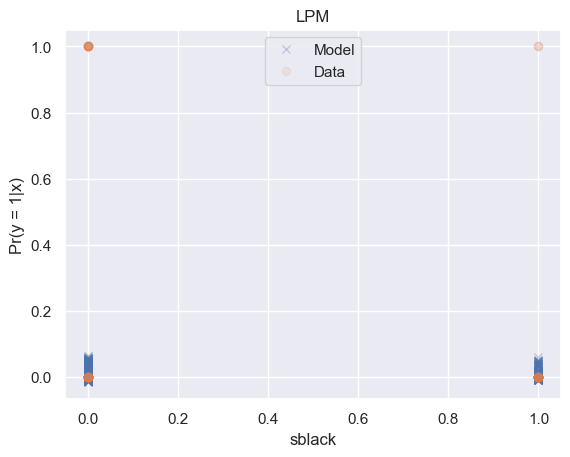

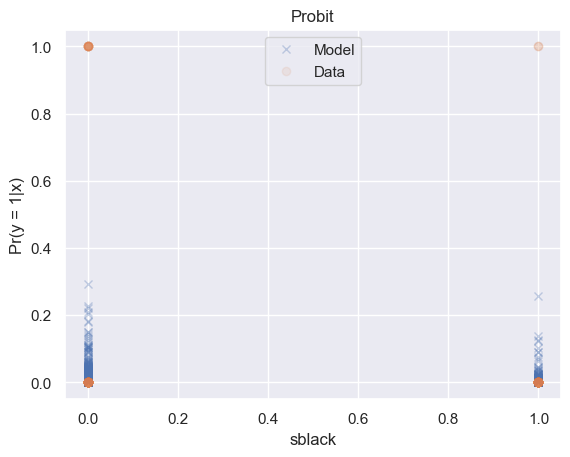

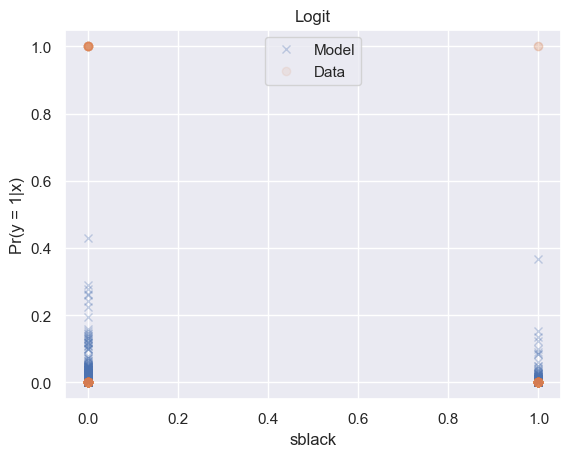

In [167]:
def plot_fit(theta, yhat, y, x, k:int, title=None): 
    '''plot_fit(): plot the predictions, f_predict(theta,x), from the model against the data
    Args. 
        theta: array of parameters, 
        yhat: fitted values 
        y: actual outcome 
        x: regressors 
        k: index for the regressor, x[:,k], to put on the x axis 
    '''
    
    fig, ax = plt.subplots(); 
    ax.plot(x[:,k], yhat, 'x', alpha=0.3, label='Model'); 
    ax.plot(x[:,k], y,    'o', alpha=0.1, label='Data')
    
    # nicify 
    ax.set_xlabel(x_label[k]); 
    ax.set_ylabel('Pr(y = 1|x)')
    ax.set_title(title)
    ax.legend()

k = 1 # which variable to put on the x-axis 

yhatO = lm.predict(ols_results['b_hat'], x)
plot_fit(ols_results['b_hat'], yhatO, y, x, k, 'LPM')

yhatP = project3_probit.predict(probit_results['theta'], x)
plot_fit(probit_results['theta'], yhatP, y, x, k, 'Probit')

yhatL = project3_logit.predict(logit_results['theta'], x)
plot_fit(logit_results['theta'], yhatL, y, x, k, 'Logit')

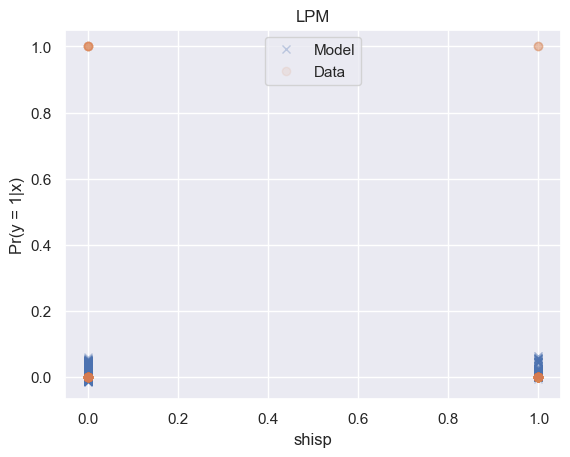

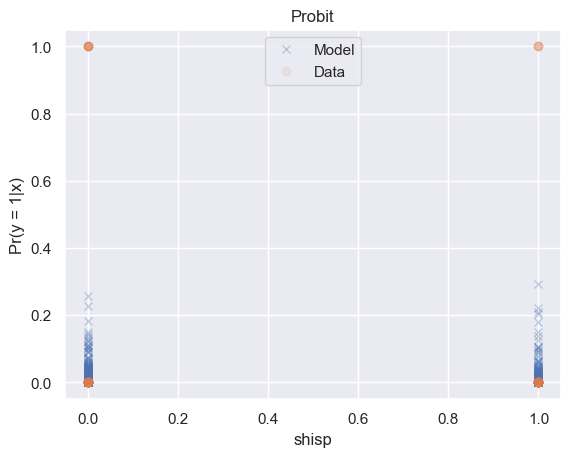

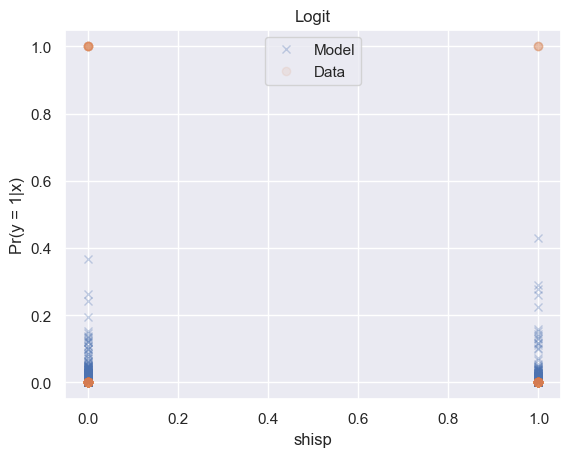

In [168]:
def plot_fit(theta, yhat, y, x, k:int, title=None): 
    '''plot_fit(): plot the predictions, f_predict(theta,x), from the model against the data
    Args. 
        theta: array of parameters, 
        yhat: fitted values 
        y: actual outcome 
        x: regressors 
        k: index for the regressor, x[:,k], to put on the x axis 
    '''
    
    fig, ax = plt.subplots(); 
    ax.plot(x[:,k], yhat, 'x', alpha=0.3, label='Model'); 
    ax.plot(x[:,k], y,    'o', alpha=0.1, label='Data')
    
    # nicify 
    ax.set_xlabel(x_label[k]); 
    ax.set_ylabel('Pr(y = 1|x)')
    ax.set_title(title)
    ax.legend()

k = 2 # which variable to put on the x-axis 

yhatO = lm.predict(ols_results['b_hat'], x)
plot_fit(ols_results['b_hat'], yhatO, y, x, k, 'LPM')

yhatP = project3_probit.predict(probit_results['theta'], x)
plot_fit(probit_results['theta'], yhatP, y, x, k, 'Probit')

yhatL = project3_logit.predict(logit_results['theta'], x)
plot_fit(logit_results['theta'], yhatL, y, x, k, 'Logit')

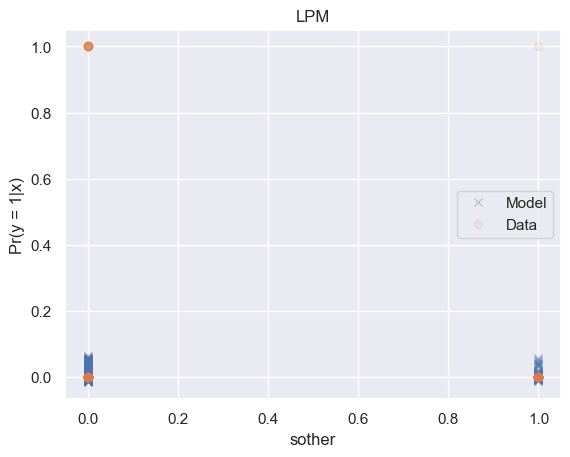

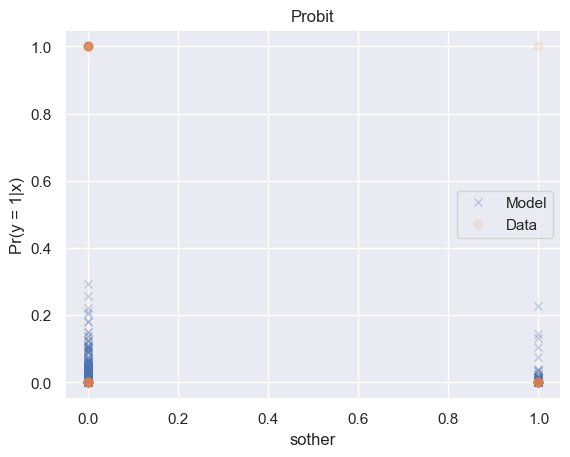

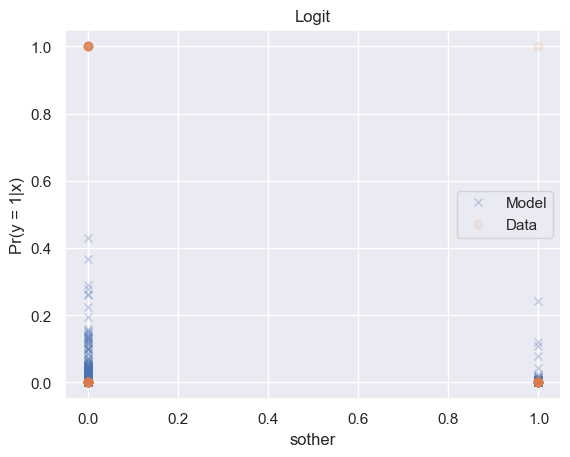

In [169]:
def plot_fit(theta, yhat, y, x, k:int, title=None): 
    '''plot_fit(): plot the predictions, f_predict(theta,x), from the model against the data
    Args. 
        theta: array of parameters, 
        yhat: fitted values 
        y: actual outcome 
        x: regressors 
        k: index for the regressor, x[:,k], to put on the x axis 
    '''
    
    fig, ax = plt.subplots(); 
    ax.plot(x[:,k], yhat, 'x', alpha=0.3, label='Model'); 
    ax.plot(x[:,k], y,    'o', alpha=0.1, label='Data')
    
    # nicify 
    ax.set_xlabel(x_label[k]); 
    ax.set_ylabel('Pr(y = 1|x)')
    ax.set_title(title)
    ax.legend()

k = 3 # which variable to put on the x-axis 

yhatO = lm.predict(ols_results['b_hat'], x)
plot_fit(ols_results['b_hat'], yhatO, y, x, k, 'LPM')

yhatP = project3_probit.predict(probit_results['theta'], x)
plot_fit(probit_results['theta'], yhatP, y, x, k, 'Probit')

yhatL = project3_logit.predict(logit_results['theta'], x)
plot_fit(logit_results['theta'], yhatL, y, x, k, 'Logit')